# SAP Stock Price Prediction

In [1]:
import fix_yahoo_finance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt   # Import matplotlib
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from mpl_finance import candlestick_ohlc

import numpy as np
import math

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline

In [46]:
# setup the folder path
path = 'C:\\Users\\fenli\\OneDrive - Deloitte (O365D)\\Deep learning\\Learning\\'
path_data = path + 'Data\\'
path_model = path + 'Model\\'

In [3]:
# setup the period to get the stock data
start_date = "2003-01-01"
end_date = "2019-03-27"

In [4]:
# download data using fix_yahoo_finance from YAHOO
data_sap = yf.download("SAP.DE", start=start_date, end=end_date)
data_oracle = yf.download("ORCL", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [9]:
# save data
data_sap.to_pickle(path_data + 'sap_stock_price')
data_oracle.to_pickle(path_data + 'oracle_stock_price')

In [4]:
# load data 
data_sap = pd.read_pickle(path_data + 'sap_stock_price')
data_oracle = pd.read_pickle(path_data + 'oracle_stock_price')

In [5]:
data_sap.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-12-31,18.879999,18.879999,18.879999,18.879999,13.962929,0
2003-01-01,18.879999,18.879999,18.879999,18.879999,13.962929,0
2003-01-02,18.725000,20.334999,18.530001,20.200001,14.939153,4668528
2003-01-03,20.424999,21.500000,20.262501,21.522499,15.917223,7698848
2003-01-06,21.475000,22.222500,21.010000,21.947500,16.231535,6265092


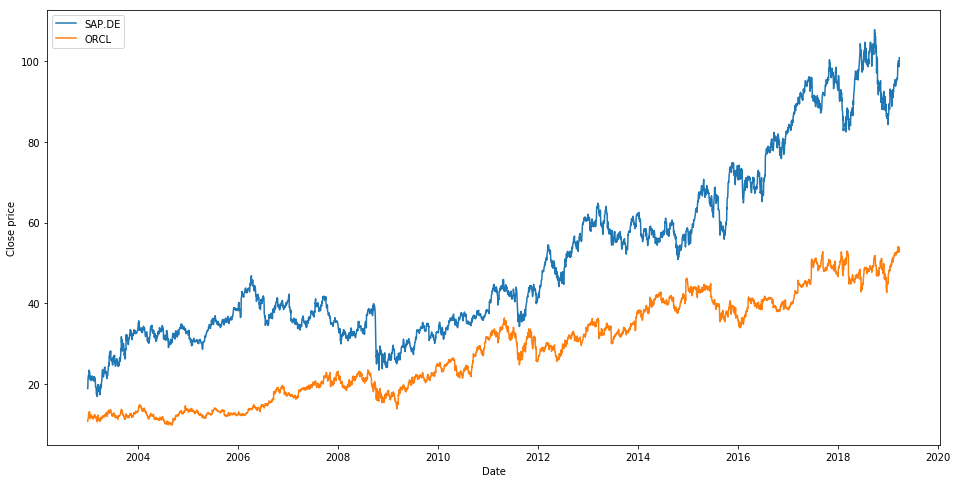

In [6]:
#plot
plt.figure(figsize=(16,8))
plt.plot(data_sap['Close'], label='SAP.DE')
plt.plot(data_oracle['Close'], label='ORCL')
plt.ylabel('Close price')
plt.xlabel('Date')
plt.legend()

# Modelling

## A Simple LSTM Model

In [7]:
# use number of previous days value to predict next day value
# tried look_back = 5, overfitting for 100 epochs
look_back = 40

In [8]:
# define a function to split the data based on the look_back period
def create_dataset(dataset, look_back=look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [236]:
df = data_sap.reset_index()
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [237]:
df_d = df[['Date']]
df = df[['Close']]

In [238]:
dataset = df.Close   # only select the 'Close' the closing price
dataset_d = df_d.Date 

In [239]:
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
#dataset = list(map(lambda x: x / scalar, dataset))
dataset = dataset / scalar   # data normolisation using max and min

In [241]:
# create data set
data_X, data_Y = create_dataset(dataset)
data_X_d, data_Y_d = create_dataset(dataset_d)

In [242]:
data_X[3,:]

array([0.23680373, 0.24147984, 0.2454958 , 0.23628111, 0.2489341 ,
       0.25812128, 0.25223488, 0.25369275, 0.24962178, 0.24546827,
       0.23441066, 0.23105486, 0.23055975, 0.23339291, 0.24167238,
       0.23182504, 0.23064226, 0.23490578, 0.2299546 , 0.23661117,
       0.23562096, 0.24197496, 0.23487827, 0.23793149, 0.23509833,
       0.23353046, 0.23196259, 0.23892173, 0.23754641, 0.23518084,
       0.22802915, 0.23471324, 0.240077  , 0.23311785, 0.23432815,
       0.2350433 , 0.23600605, 0.22541602, 0.22252785, 0.21166275],
      dtype=float32)

In [243]:
data_Y[3]

0.21221289

In [244]:
train_size = int(len(data_X) * 0.8)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [185]:
train_X.shape

(3283, 40)

In [186]:
train_Y.shape

(3283,)

In [187]:
train_X = train_X.reshape(-1, 1, look_back)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, look_back)
test_Y = test_Y.reshape(-1, 1, 1)

In [188]:
train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)
test_y = torch.from_numpy(test_Y)

In [76]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # linner
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # linner
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [77]:
# build your model
net = lstm_reg(input_size=look_back, hidden_size=60,output_size=1,num_layers=2)

In [78]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [24]:
train_x

tensor([[[0.2077, 0.2077, 0.2223,  ..., 0.2343, 0.2350, 0.2360]],

        [[0.2077, 0.2223, 0.2368,  ..., 0.2350, 0.2360, 0.2254]],

        [[0.2223, 0.2368, 0.2415,  ..., 0.2360, 0.2254, 0.2225]],

        ...,

        [[0.7958, 0.8078, 0.8041,  ..., 0.8032, 0.8032, 0.8017]],

        [[0.8078, 0.8041, 0.8114,  ..., 0.8032, 0.8017, 0.8155]],

        [[0.8041, 0.8114, 0.8047,  ..., 0.8017, 0.8155, 0.8074]]])

In [86]:
for epoch in range(100):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    var_x_test = Variable(test_x)
    var_y_test = Variable(test_y)
    # forward
    out = net(var_x)
    loss = criterion(out, var_y)
    out_test = net(var_x_test)
    loss_test = criterion(out_test, var_y_test)
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 1 == 0: # print every 1 epoch
        print('Epoch: {}, Train loss: {:.5f}, Val loss: {:.5f}'.format(epoch + 1, loss.data, loss_test.data))
        
    # save model in every 10 epoch
    if (epoch + 1) % 10 == 0:
        #torch.save(net.state_dict(), path_model+'train_valid_exp4-epoch{}.pth'.format(epoch+1)) 
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, path_model+'train_valid_exp4-epoch{}.pth'.format(epoch+1))      

Epoch: 1, Train loss: 0.00031, Val loss: 0.01440
Epoch: 2, Train loss: 0.00031, Val loss: 0.01432
Epoch: 3, Train loss: 0.00031, Val loss: 0.01412
Epoch: 4, Train loss: 0.00031, Val loss: 0.01369
Epoch: 5, Train loss: 0.00030, Val loss: 0.01358
Epoch: 6, Train loss: 0.00030, Val loss: 0.01345
Epoch: 7, Train loss: 0.00030, Val loss: 0.01307
Epoch: 8, Train loss: 0.00030, Val loss: 0.01296
Epoch: 9, Train loss: 0.00030, Val loss: 0.01286
Epoch: 10, Train loss: 0.00030, Val loss: 0.01251
Epoch: 11, Train loss: 0.00029, Val loss: 0.01242
Epoch: 12, Train loss: 0.00029, Val loss: 0.01230
Epoch: 13, Train loss: 0.00029, Val loss: 0.01200
Epoch: 14, Train loss: 0.00029, Val loss: 0.01194
Epoch: 15, Train loss: 0.00029, Val loss: 0.01181
Epoch: 16, Train loss: 0.00029, Val loss: 0.01155
Epoch: 17, Train loss: 0.00029, Val loss: 0.01152
Epoch: 18, Train loss: 0.00029, Val loss: 0.01136
Epoch: 19, Train loss: 0.00029, Val loss: 0.01116
Epoch: 20, Train loss: 0.00028, Val loss: 0.01115
Epoch: 21

In [89]:
epoch = 60
path_model+'train_valid_exp4-epoch{}.pth'.format(epoch)

'C:\\Users\\fenli\\OneDrive - Deloitte (O365D)\\Deep learning\\Learning\\Model\\train_valid_exp4-epoch60.pth'

In [91]:
## to get back the saved model with specific epoch
epoch = 60
PATH = path_model+'train_valid_exp4-epoch{}.pth'.format(epoch)
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

net.eval()
# - or -
#net.train()

lstm_reg(
  (rnn): LSTM(40, 60, num_layers=2)
  (reg): Linear(in_features=60, out_features=1, bias=True)
)

In [101]:
# same the best model so far
## setup the path to store the model
filename = 'SAP_LSTM'
filetype = 'state_dict'
filedate = '20190328_best1'
file_inference = path_model + filename + '_' + filetype + '_' + filedate + '.pth'
file_full = path_model + filename + '_' + filedate + '.pth'
torch.save(net.state_dict(), file_inference)   # inference
net.load_state_dict(torch.load(file_inference))

In [113]:
# start to train a
net.train()

lstm_reg(
  (rnn): LSTM(40, 60, num_layers=2)
  (reg): Linear(in_features=60, out_features=1, bias=True)
)

In [103]:
# now lets choose a smaller learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [114]:
for epoch in range(100):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    var_x_test = Variable(test_x)
    var_y_test = Variable(test_y)
    # forward
    out = net(var_x)
    loss = criterion(out, var_y)
    out_test = net(var_x_test)
    loss_test = criterion(out_test, var_y_test)
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 1 == 0: # print every 1 epoch
        print('Epoch: {}, Train loss: {:.5f}, Val loss: {:.5f}'.format(epoch + 1, loss.data, loss_test.data))
        
    # save model in every 10 epoch
    if (epoch + 1) % 10 == 0:
        #torch.save(net.state_dict(), path_model+'train_valid_exp4-epoch{}.pth'.format(epoch+1)) 
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, path_model+'train_valid_exp4-epoch{}.pth'.format(epoch+1))   

Epoch: 1, Train loss: 0.00017, Val loss: 0.00169
Epoch: 2, Train loss: 0.00018, Val loss: 0.00163
Epoch: 3, Train loss: 0.00017, Val loss: 0.00166
Epoch: 4, Train loss: 0.00018, Val loss: 0.00169
Epoch: 5, Train loss: 0.00017, Val loss: 0.00161
Epoch: 6, Train loss: 0.00017, Val loss: 0.00157
Epoch: 7, Train loss: 0.00017, Val loss: 0.00160
Epoch: 8, Train loss: 0.00017, Val loss: 0.00159
Epoch: 9, Train loss: 0.00017, Val loss: 0.00153
Epoch: 10, Train loss: 0.00017, Val loss: 0.00152
Epoch: 11, Train loss: 0.00017, Val loss: 0.00155
Epoch: 12, Train loss: 0.00017, Val loss: 0.00152
Epoch: 13, Train loss: 0.00017, Val loss: 0.00147
Epoch: 14, Train loss: 0.00016, Val loss: 0.00147
Epoch: 15, Train loss: 0.00017, Val loss: 0.00147
Epoch: 16, Train loss: 0.00016, Val loss: 0.00143
Epoch: 17, Train loss: 0.00016, Val loss: 0.00140
Epoch: 18, Train loss: 0.00016, Val loss: 0.00141
Epoch: 19, Train loss: 0.00016, Val loss: 0.00139
Epoch: 20, Train loss: 0.00016, Val loss: 0.00136
Epoch: 21

In [115]:
## to get back the saved model with specific epoch
epoch = 60
PATH = path_model+'train_valid_exp4-epoch{}.pth'.format(epoch)
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#net.eval()
# - or -
#net.train()

In [116]:
# save the best model so far
## setup the path to store the model
filename = 'SAP_LSTM'
filetype = 'state_dict'
filedate = '20190328_best4'
file_inference = path_model + filename + '_' + filetype + '_' + filedate + '.pth'
file_full = path_model + filename + '_' + filedate + '.pth'
torch.save(net.state_dict(), file_inference)   # inference
net.load_state_dict(torch.load(file_inference))

In [126]:
## train again using a smaller learning rate
net.train()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [127]:
for epoch in range(100):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    var_x_test = Variable(test_x)
    var_y_test = Variable(test_y)
    # forward
    out = net(var_x)
    loss = criterion(out, var_y)
    out_test = net(var_x_test)
    loss_test = criterion(out_test, var_y_test)
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 1 == 0: # print every 1 epoch
        print('Epoch: {}, Train loss: {:.5f}, Val loss: {:.5f}'.format(epoch + 1, loss.data, loss_test.data))
        
    # save model in every 10 epoch
    if (epoch + 1) % 10 == 0:
        #torch.save(net.state_dict(), path_model+'train_valid_exp4-epoch{}.pth'.format(epoch+1)) 
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, path_model+'train_valid_exp4-epoch{}.pth'.format(epoch+1))   

Epoch: 1, Train loss: 0.00014, Val loss: 0.00121
Epoch: 2, Train loss: 0.00017, Val loss: 0.00115
Epoch: 3, Train loss: 0.00014, Val loss: 0.00116
Epoch: 4, Train loss: 0.00015, Val loss: 0.00123
Epoch: 5, Train loss: 0.00015, Val loss: 0.00127
Epoch: 6, Train loss: 0.00015, Val loss: 0.00124
Epoch: 7, Train loss: 0.00014, Val loss: 0.00119
Epoch: 8, Train loss: 0.00014, Val loss: 0.00116
Epoch: 9, Train loss: 0.00015, Val loss: 0.00115
Epoch: 10, Train loss: 0.00015, Val loss: 0.00115
Epoch: 11, Train loss: 0.00014, Val loss: 0.00116
Epoch: 12, Train loss: 0.00014, Val loss: 0.00118
Epoch: 13, Train loss: 0.00014, Val loss: 0.00120
Epoch: 14, Train loss: 0.00014, Val loss: 0.00122
Epoch: 15, Train loss: 0.00014, Val loss: 0.00122
Epoch: 16, Train loss: 0.00014, Val loss: 0.00121
Epoch: 17, Train loss: 0.00014, Val loss: 0.00118
Epoch: 18, Train loss: 0.00014, Val loss: 0.00117
Epoch: 19, Train loss: 0.00014, Val loss: 0.00116
Epoch: 20, Train loss: 0.00014, Val loss: 0.00116
Epoch: 21

In [132]:
## to get back the saved model with specific epoch
epoch = 20
PATH = path_model+'train_valid_exp4-epoch{}.pth'.format(epoch)
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#net.eval()
# - or -
#net.train()

In [133]:
# save the best model so far
## setup the path to store the model
filename = 'SAP_LSTM'
filetype = 'state_dict'
filedate = '20190328_best5'
file_inference = path_model + filename + '_' + filetype + '_' + filedate + '.pth'
file_full = path_model + filename + '_' + filedate + '.pth'
torch.save(net.state_dict(), file_inference)   # inference
net.load_state_dict(torch.load(file_inference))

In [173]:
# load the best model "SAP_LSTM_state_dict_20190328_best5.pth"
filename = 'SAP_LSTM'
filetype = 'state_dict'
filedate = '20190328_best5'
file_inference = path_model + filename + '_' + filetype + '_' + filedate + '.pth'
net.load_state_dict(torch.load(file_inference))

In [65]:
## save the model Inference and full model
# torch.save(net.state_dict(), file_inference)   # inference
# torch.save(net, file_full)   # full model

## load the model inference and full model
# inference 
# Model class must be defined somewhere
# net.load_state_dict(torch.load(file_inference))

## load the model inference and full model
# full model 
# Model class must be defined somewhere
# net = torch.load(file_full)


In [137]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
rnn.weight_ih_l0 	 torch.Size([240, 40])
rnn.weight_hh_l0 	 torch.Size([240, 60])
rnn.bias_ih_l0 	 torch.Size([240])
rnn.bias_hh_l0 	 torch.Size([240])
rnn.weight_ih_l1 	 torch.Size([240, 60])
rnn.weight_hh_l1 	 torch.Size([240, 60])
rnn.bias_ih_l1 	 torch.Size([240])
rnn.bias_hh_l1 	 torch.Size([240])
reg.weight 	 torch.Size([1, 60])
reg.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {1840105321672: {'step': 20, 'exp_avg': tensor([[-2.2364e-08, -2.2587e-08, -2.3196e-08,  ..., -1.3816e-08,
         -9.5922e-09, -6.3129e-09],
        [-3.1170e-08, -3.0846e-08, -2.8568e-08,  ..., -8.5447e-08,
         -1.0673e-07, -1.3782e-07],
        [-1.8491e-08, -1.7961e-08, -1.8190e-08,  ..., -5.2285e-09,
          3.0409e-09,  1.2967e-08],
        ...,
        [-5.2113e-08, -5.1398e-08, -5.1590e-08,  ..., -2.1028e-08,
         -8.8298e-10,  2.0973e-08],
        [ 2.0740e-07,  2.1343e-07,  2.1898e-07,  ...,  3.8060e-07,
          4.9484e-07,  6.5160e-07],
        [ 6.4804

In [245]:
net = net.eval()  # change to test mode

In [246]:
# prepare the data for prediction
data_X_pred = data_X.reshape(-1, 1, look_back)
data_X_pred = torch.from_numpy(data_X_pred)
var_data_pred = Variable(data_X_pred)


In [249]:
# use the model to predict
pred_test = net(var_data_pred) # prediction
pred_test = pred_test.view(-1).data.numpy()

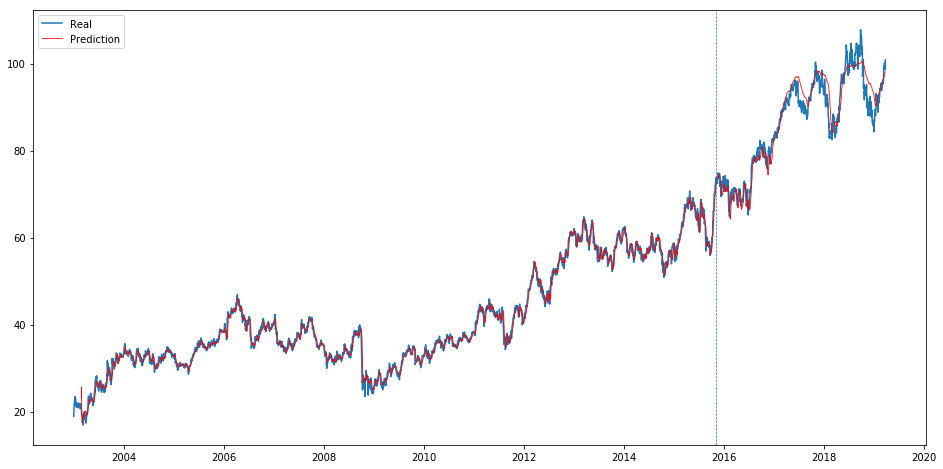

In [257]:
# plot the results
plt.figure(figsize=(16,8))
#plt.plot(dataset * scalar, label='Real')
#plt.plot(pred_test * scalar, 'r', label='Prediction')

plt.plot(dataset_d, dataset * scalar, label='Real')
plt.plot(data_Y_d, pred_test * scalar,'r', label='Prediction', linewidth=0.8)

plt.legend(loc='best')
plt.axvline(x=dataset_d[train_size], linestyle='--',linewidth=0.7)


In [140]:
# get prediction

In [335]:
# you may need to get the latest data from yahoo

In [355]:
df_prediction = data_sap.reset_index()
df_prediction_d = df_prediction[['Date']]
df_prediction = df_prediction[['Close']]
dataset_prediction = df_prediction.Close   # only select the 'Close' the closing price
dataset_prediction_d = df_prediction_d.Date
dataset_prediction = dataset_prediction.astype('float32')
#dataset = list(map(lambda x: x / scalar, dataset))
dataset_prediction = dataset_prediction / scalar   # data normolisation using max and min


In [356]:
dataset_prediction = dataset_prediction[len(dataset_prediction)-look_back*2:len(dataset_prediction)]
dataset_prediction = dataset_prediction.reset_index()
dataset_prediction = dataset_prediction['Close']

In [358]:
data_X_prediction, data_Y_prediction = create_dataset(dataset_prediction)


In [359]:
data_X_prediction

array([[0.9993673 , 1.0023379 , 1.0003575 , ..., 1.0195022 , 1.0162013 ,
        0.98814464],
       [1.0023379 , 1.0003575 , 1.0178517 , ..., 1.0162013 , 0.98814464,
        0.9773621 ],
       [1.0003575 , 1.0178517 , 1.0116901 , ..., 0.98814464, 0.9773621 ,
        0.9929858 ],
       ...,
       [1.0195022 , 1.0162013 , 0.98814464, ..., 1.1018016 , 1.1013615 ,
        1.1013615 ],
       [1.0162013 , 0.98814464, 0.9773621 , ..., 1.1013615 , 1.1013615 ,
        1.0857378 ],
       [0.98814464, 0.9773621 , 0.9929858 , ..., 1.1013615 , 1.0857378 ,
        1.0852977 ]], dtype=float32)

In [360]:
# prepare the data for prediction
data_X_prediction = data_X_prediction.reshape(-1, 1, look_back)
data_X_prediction = torch.from_numpy(data_X_prediction)
var_data_prediction = Variable(data_X_prediction)

In [392]:
# final prediction
final_prediction_result = net(var_data_prediction)[len(var_data_prediction)-1] * scalar
final_prediction_result

tensor([[98.1647]], grad_fn=<MulBackward0>)

In [390]:
# date of the last records
ddd = df_prediction_d['Date'][len(df_prediction_d)-1]
ddd

Timestamp('2019-03-26 00:00:00')

In [393]:
# closing price of the last records
df_prediction['Close'][len(df_prediction)-1]

100.860001

In [141]:
######## below is an attention model, not ready to use

In [79]:
#stock_frame1 = data_sap.reset_index()
#stock_frame2 = data_oracle.reset_index()

In [84]:
ENCODER_HIDDEN_SIZE = 64
DECODER_HIDDEN_SIZE = 64
#DRIVING = 'stocks/MSFT.US.csv'
#TARGET = 'stocks/AAPL.US.csv'

DRIVING = data_sap.reset_index()
TARGET = data_oracle.reset_index()

In [82]:
class Dataset:

    def __init__(self, driving_csv, target_csv, T, split_ratio=0.8, normalized=False):
        #stock_frame1 = pd.read_csv(driving_csv)
        #stock_frame2 = pd.read_csv(target_csv)
        stock_frame1 = driving_csv
        stock_frame2 = target_csv       
        if stock_frame1.shape[0] > stock_frame2.shape[0]:
            stock_frame1 = self.crop_stock(stock_frame1, stock_frame2['Date'][0]).reset_index()
        else:
            stock_frame2 = self.crop_stock(stock_frame2, stock_frame1['Date'][0]).reset_index()
        stock_frame1 = stock_frame1['Close'].fillna(method='pad')
        stock_frame2 = stock_frame2['Close'].fillna(method='pad')
        self.train_size = int(split_ratio * (stock_frame2.shape[0] - T - 1))
        self.test_size = stock_frame2.shape[0] - T  - 1 - self.train_size
        if normalized:
            stock_frame2 = stock_frame2 - stock_frame2.mean()
        self.X, self.y, self.y_seq = self.time_series_gen(stock_frame1, stock_frame2, T)
        #self.X = self.percent_normalization(self.X)
        #self.y = self.percent_normalization(self.y)
        #self.y_seq = self.percent_normalization(self.y_seq)

    def get_size(self):
        return self.train_size, self.test_size

    def get_num_features(self):
        return self.X.shape[1]

    def get_train_set(self):
        return self.X[:self.train_size], self.y[:self.train_size], self.y_seq[:self.train_size]

    def get_test_set(self):
        return self.X[self.train_size:], self.y[self.train_size:], self.y_seq[self.train_size:]

    def time_series_gen(self, X, y, T):
        ts_x, ts_y, ts_y_seq = [], [], []
        for i in range(len(X) - T - 1):
            last = i + T
            ts_x.append(X[i: last])
            ts_y.append(y[last])
            ts_y_seq.append(y[i: last])
        return np.array(ts_x), np.array(ts_y), np.array(ts_y_seq)

    def crop_stock(self, df, date):
        start = df.loc[df['Date'] == date].index[0]
        return df[start: ]

    def log_normalization(self, X):
        X_norm = np.zeros(X.shape[0])
        X_norm[0] = 0
        for i in range(1, X.shape[0]):
            X_norm[i] = math.log(X[i] / X[i-1])
        return X_norm

    def percent_normalization(self, X):
        if len(X.shape) == 2:
            X_norm = np.zeros((X.shape[0], X.shape[1]))
            for i in range(1, X.shape[0]):
                X_norm[i, 0] = 0
                X_norm[i] = np.true_divide(X[i] - X[i-1], X[i-1])
        else:
            X_norm = np.zeros(X.shape[0])
            X_norm[0] = 0
            for i in range(1, X.shape[0]):
                X_norm[i] = (X[i] - X[i-1]) / X[i]
        return X_norm

In [85]:
class AttnEncoder(nn.Module):

    def __init__(self, input_size, hidden_size, time_step):
        super(AttnEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.T = time_step

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1)
        self.attn1 = nn.Linear(in_features=2 * hidden_size, out_features=self.T)
        self.attn2 = nn.Linear(in_features=self.T, out_features=self.T)
        self.tanh = nn.Tanh()
        self.attn3 = nn.Linear(in_features=self.T, out_features=1)
        #self.attn = nn.Sequential(attn1, attn2, nn.Tanh(), attn3)


    def forward(self, driving_x):
        batch_size = driving_x.size(0)
        # batch_size * time_step * hidden_size
        code = self.init_variable(batch_size, self.T, self.hidden_size)
        # initialize hidden state
        h = self.init_variable(1, batch_size, self.hidden_size)
        # initialize cell state
        s = self.init_variable(1, batch_size, self.hidden_size)
        for t in range(self.T):
            # batch_size * input_size * (2 * hidden_size + time_step)
            x = torch.cat((self.embedding_hidden(h), self.embedding_hidden(s)), 2)
            z1 = self.attn1(x)
            z2 = self.attn2(driving_x.permute(0, 2, 1))
            x = z1 + z2
            # batch_size * input_size * 1
            z3 = self.attn3(self.tanh(x))
            if batch_size > 1:
                attn_w = F.softmax(z3.view(batch_size, self.input_size), dim=1)
            else:
                attn_w = self.init_variable(batch_size, self.input_size) + 1
            # batch_size * input_size
            weighted_x = torch.mul(attn_w, driving_x[:, t, :])
            _, states = self.lstm(weighted_x.unsqueeze(0), (h, s))
            h = states[0]
            s = states[1]

            # encoding result
            # batch_size * time_step * encoder_hidden_size
            code[:, t, :] = h

        return code

    def init_variable(self, *args):
        zero_tensor = torch.zeros(args)
        if torch.cuda.is_available():
            zero_tensor = zero_tensor.cuda()
        return Variable(zero_tensor)

    def embedding_hidden(self, x):
        return x.repeat(self.input_size, 1, 1).permute(1, 0, 2)


class AttnDecoder(nn.Module):

    def __init__(self, code_hidden_size, hidden_size, time_step):
        super(AttnDecoder, self).__init__()
        self.code_hidden_size = code_hidden_size
        self.hidden_size = hidden_size
        self.T = time_step

        self.attn1 = nn.Linear(in_features=2 * hidden_size, out_features=code_hidden_size)
        self.attn2 = nn.Linear(in_features=code_hidden_size, out_features=code_hidden_size)
        self.tanh = nn.Tanh()
        self.attn3 = nn.Linear(in_features=code_hidden_size, out_features=1)
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        self.tilde = nn.Linear(in_features=self.code_hidden_size + 1, out_features=1)
        self.fc1 = nn.Linear(in_features=code_hidden_size + hidden_size, out_features=hidden_size)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, h, y_seq):
        batch_size = h.size(0)
        d = self.init_variable(1, batch_size, self.hidden_size)
        s = self.init_variable(1, batch_size, self.hidden_size)
        ct = self.init_variable(batch_size, self.hidden_size)

        for t in range(self.T):
            # batch_size * time_step * (encoder_hidden_size + decoder_hidden_size)
            x = torch.cat((self.embedding_hidden(d), self.embedding_hidden(s)), 2)
            z1 = self.attn1(x)
            z2 = self.attn2(h)
            x = z1 + z2
            # batch_size * time_step * 1
            z3 = self.attn3(self.tanh(x))
            if batch_size > 1:
                beta_t = F.softmax(z3.view(batch_size, -1), dim=1)
            else:
                beta_t = self.init_variable(batch_size, self.code_hidden_size) + 1
            # batch_size * encoder_hidden_size
            ct = torch.bmm(beta_t.unsqueeze(1), h).squeeze(1)
            if t < self.T - 1:
                yc = torch.cat((y_seq[:, t].unsqueeze(1), ct), dim=1)
                y_tilde = self.tilde(yc)
                _, states = self.lstm(y_tilde.unsqueeze(0), (d, s))
                d = states[0]
                s = states[1]
        # batch_size * 1
        y_res = self.fc2(self.fc1(torch.cat((d.squeeze(0), ct), dim=1)))
        return y_res

    def init_variable(self, *args):
        zero_tensor = torch.zeros(args)
        if torch.cuda.is_available():
            zero_tensor = zero_tensor.cuda()
        return Variable(zero_tensor)

    def embedding_hidden(self, x):
        return x.repeat(self.T, 1, 1).permute(1, 0, 2)



In [88]:
import argparse
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.autograd import Variable
#from model import AttnEncoder, AttnDecoder
#from dataset import Dataset
from torch import optim
#import config

class Trainer:

    def __init__(self, driving, target, time_step, split, lr):
        self.dataset = Dataset(driving, target, time_step, split)
        self.encoder = AttnEncoder(input_size=self.dataset.get_num_features(), hidden_size=config.ENCODER_HIDDEN_SIZE, time_step=time_step)
        self.decoder = AttnDecoder(code_hidden_size=config.ENCODER_HIDDEN_SIZE, hidden_size=config.DECODER_HIDDEN_SIZE, time_step=time_step)
        if torch.cuda.is_available():
            self.encoder = self.encoder.cuda()
            self.decoder = self.decoder.cuda()
        self.encoder_optim = optim.Adam(self.encoder.parameters(), lr)
        self.decoder_optim = optim.Adam(self.decoder.parameters(), lr)
        self.loss_func = nn.MSELoss()
        self.train_size, self.test_size = self.dataset.get_size()

    def train_minibatch(self, num_epochs, batch_size, interval):
        x_train, y_train, y_seq_train = self.dataset.get_train_set()
        for epoch in range(num_epochs):
            i = 0
            loss_sum = 0
            while (i < self.train_size):
                self.encoder_optim.zero_grad()
                self.decoder_optim.zero_grad()
                batch_end = i + batch_size
                if (batch_end >= self.train_size):
                    batch_end = self.train_size
                var_x = self.to_variable(x_train[i: batch_end])
                var_y = self.to_variable(y_train[i: batch_end])
                var_y_seq = self.to_variable(y_seq_train[i: batch_end])
                if var_x.dim() == 2:
                    var_x = var_x.unsqueeze(2)
                code = self.encoder(var_x)
                y_res = self.decoder(code, var_y_seq)
                loss = self.loss_func(y_res, var_y)
                loss.backward()
                self.encoder_optim.step()
                self.decoder_optim.step()
                # print('[%d], loss is %f' % (epoch, 10000 * loss.data[0]))
                loss_sum += loss.data[0]
                i = batch_end
            print('epoch [%d] finished, the average loss is %f' % (epoch, loss_sum))
            if (epoch + 1) % (interval) == 0 or epoch + 1 == num_epochs:
                torch.save(self.encoder.state_dict(), 'models/encoder' + str(epoch + 1) + '-norm' + '.model')
                torch.save(self.decoder.state_dict(), 'models/decoder' + str(epoch + 1) + '-norm' + '.model')

    def test(self, num_epochs, batch_size):
        x_train, y_train, y_seq_train = self.dataset.get_train_set()
        x_test, y_test, y_seq_test = self.dataset.get_test_set()
        y_pred_train = self.predict(x_train, y_train, y_seq_train, batch_size)
        y_pred_test = self.predict(x_test, y_test, y_seq_test, batch_size)
        plt.figure(figsize=(8,6), dpi=100)
        plt.plot(range(2000, self.train_size), y_train[2000:], label='train truth', color='black')
        plt.plot(range(self.train_size, self.train_size + self.test_size), y_test, label='ground truth', color='black')
        plt.plot(range(2000, self.train_size), y_pred_train[2000:], label='predicted train', color='red')
        plt.plot(range(self.train_size, self.train_size + self.test_size), y_pred_test, label='predicted test', color='blue')
        plt.xlabel('Days')
        plt.ylabel('Stock price of AAPL.US(USD)')
        plt.savefig('results/res-' + str(num_epochs) +'-' + str(batch_size) + '.png')


    def predict(self, x, y, y_seq, batch_size):
        y_pred = np.zeros(x.shape[0])
        i = 0
        while (i < x.shape[0]):
            batch_end = i + batch_size
            if batch_end > x.shape[0]:
                batch_end = x.shape[0]
            var_x_input = self.to_variable(x[i: batch_end])
            var_y_input = self.to_variable(y_seq[i: batch_end])
            if var_x_input.dim() == 2:
                var_x_input = var_x_input.unsqueeze(2)
            code = self.encoder(var_x_input)
            y_res = self.decoder(code, var_y_input)
            for j in range(i, batch_end):
                y_pred[j] = y_res[j - i, -1]
            i = batch_end
        return y_pred


    def load_model(self, encoder_path, decoder_path):
        self.encoder.load_state_dict(torch.load(encoder_path, map_location=lambda storage, loc: storage))
        self.decoder.load_state_dict(torch.load(decoder_path, map_location=lambda storage, loc: storage))

    def to_variable(self, x):
        if torch.cuda.is_available():
            return Variable(torch.from_numpy(x).float()).cuda()
        else:
            return Variable(torch.from_numpy(x).float())



def getArgParser():
    parser = argparse.ArgumentParser(description='Train the dual-stage attention-based model on stock')
    parser.add_argument(
        '-e', '--epoch', type=int, default=1,
        help='the number of epochs')
    parser.add_argument(
        '-b', '--batch', type=int, default=1,
        help='the mini-batch size')
    parser.add_argument(
        '-s', '--split', type=float, default=0.8,
        help='the split ratio of validation set')
    parser.add_argument(
        '-i', '--interval', type=int, default=1,
        help='save models every interval epoch')
    parser.add_argument(
        '-l', '--lrate', type=float, default=0.01,
        help='learning rate')
    parser.add_argument(
        '-t', '--test', action='store_true',
        help='train or test')
    parser.add_argument(
        '-m', '--model', type=str, default='',
        help='the model name(after encoder/decoder)'
    )
    return parser


if __name__ == '__main__':
    args = getArgParser().parse_args()
    num_epochs = args.epoch
    batch_size = args.batch
    split = args.split
    interval = args.interval
    lr = args.lrate
    test = args.test
    mname = args.model
    trainer = Trainer(config.DRIVING, config.TARGET, 10, split, lr)
    if not test:
        trainer.train_minibatch(num_epochs, batch_size, interval)
    else:
        encoder_name = 'models/encoder' + mname + '.model'
        decoder_name = 'models/decoder' + mname + '.model'
        trainer.load_model(encoder_name, decoder_name)
        trainer.test(mname, batch_size)

usage: ipykernel_launcher.py [-h] [-e EPOCH] [-b BATCH] [-s SPLIT]
                             [-i INTERVAL] [-l LRATE] [-t] [-m MODEL]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\fenli\AppData\Roaming\jupyter\runtime\kernel-e39585ad-d46f-415c-a691-13d97908183d.json


SystemExit: 2

C:\Users\fenli\AppData\Local\Continuum\anaconda3\envs\fastai_1\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [91]:
Python3 trainer -e 5 -b 4 -i 1

SyntaxError: invalid syntax (<ipython-input-91-56bc3e5202ee>, line 1)

In [62]:
df = data_sap
df.loc['2018-07-25', 'Close'] = 2111.111
df.fillna(0, inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-12-31,18.879999,18.879999,18.879999,18.879999,13.962929,0
2003-01-01,18.879999,18.879999,18.879999,18.879999,13.962929,0
2003-01-02,18.725000,20.334999,18.530001,20.200001,14.939153,4668528
2003-01-03,20.424999,21.500000,20.262501,21.522499,15.917223,7698848
2003-01-06,21.475000,22.222500,21.010000,21.947500,16.231535,6265092


In [59]:
stock_frame1 = data_sap
stock_frame2 = data_oracle

In [61]:
stock_frame2

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-12-31,10.880000,10.970000,10.780000,10.800000,9.568610,26155500
2003-01-02,10.940000,11.250000,10.800000,11.210000,9.931864,32064900
2003-01-03,11.190000,11.620000,11.120000,11.560000,10.241960,30879500
2003-01-06,11.540000,12.110000,11.540000,11.960000,10.596348,45324400
2003-01-07,11.890000,12.800000,11.760000,12.690000,11.243116,72764800
2003-01-08,12.570000,12.650000,12.070000,12.120000,10.738107,53623200
2003-01-09,12.460000,13.180000,12.400000,13.010000,11.526632,71178800
2003-01-10,12.660000,13.250000,12.490000,13.070000,11.579790,52033600
2003-01-13,13.300000,13.360000,12.830000,12.930000,11.455753,40588200


In [47]:
#creating dataframe with date and the target variable
new_data = data_sap['Adj Close']

In [48]:
len(new_data)

4144

In [49]:
#splitting into train and validation
train = new_data[:round(len(new_data)*0.8)]
valid = new_data[round(len(new_data)*0.8):]

In [50]:
train.shape, valid.shape

((3315,), (829,))